# VJ Technologies Segmentation Assignment

## Submitted by: Benjamin Debbarma

# TASK 1

### DOWNLOAD DATA

In [1]:
import requests
import os
import zipfile

def download_and_extract(url, relative_path):
    # Use the current working directory as the base path
    base_path = os.getcwd()  # Gets the current working directory
    target_path = os.path.join(base_path, relative_path)
    
    # Download part
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        os.makedirs(os.path.dirname(target_path), exist_ok=True)
        with open(target_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download completed for:", target_path)
        
        # Extract part
        with zipfile.ZipFile(target_path, 'r') as zip_ref:
            extract_path = os.path.dirname(target_path)  # Extract in the same directory
            zip_ref.extractall(extract_path)
            print("Extraction completed for:", target_path)
    else:
        print("Failed to download from:", url)

# URLs of the dataset
images_url = "http://images.cocodataset.org/zips/train2017.zip"
annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# Relative paths to save the files
images_path = "Datasets_COCO/train2017.zip"
annotations_path = "Datasets_COCO/annotations_trainval2017.zip"

# Download and extract the files
download_and_extract(images_url, images_path)
download_and_extract(annotations_url, annotations_path)


Download completed for: /home/adityab/ADRL/VJT_Task1/Datasets_COCO/train2017.zip
Extraction completed for: /home/adityab/ADRL/VJT_Task1/Datasets_COCO/train2017.zip
Download completed for: /home/adityab/ADRL/VJT_Task1/Datasets_COCO/annotations_trainval2017.zip
Extraction completed for: /home/adityab/ADRL/VJT_Task1/Datasets_COCO/annotations_trainval2017.zip


### CHECK HOW MANY IMAGES ARE THERE

In [1]:
import os

base_path = os.getcwd()  # Gets the current working directory
folder_path = os.path.join(base_path, 'Datasets_COCO', 'train2017')

# List all files in the folder and count them
file_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])

print(f"There are {file_count} files in the folder.")



There are 118287 files in the folder.


### VIEW SOME RANDOM IMAGES

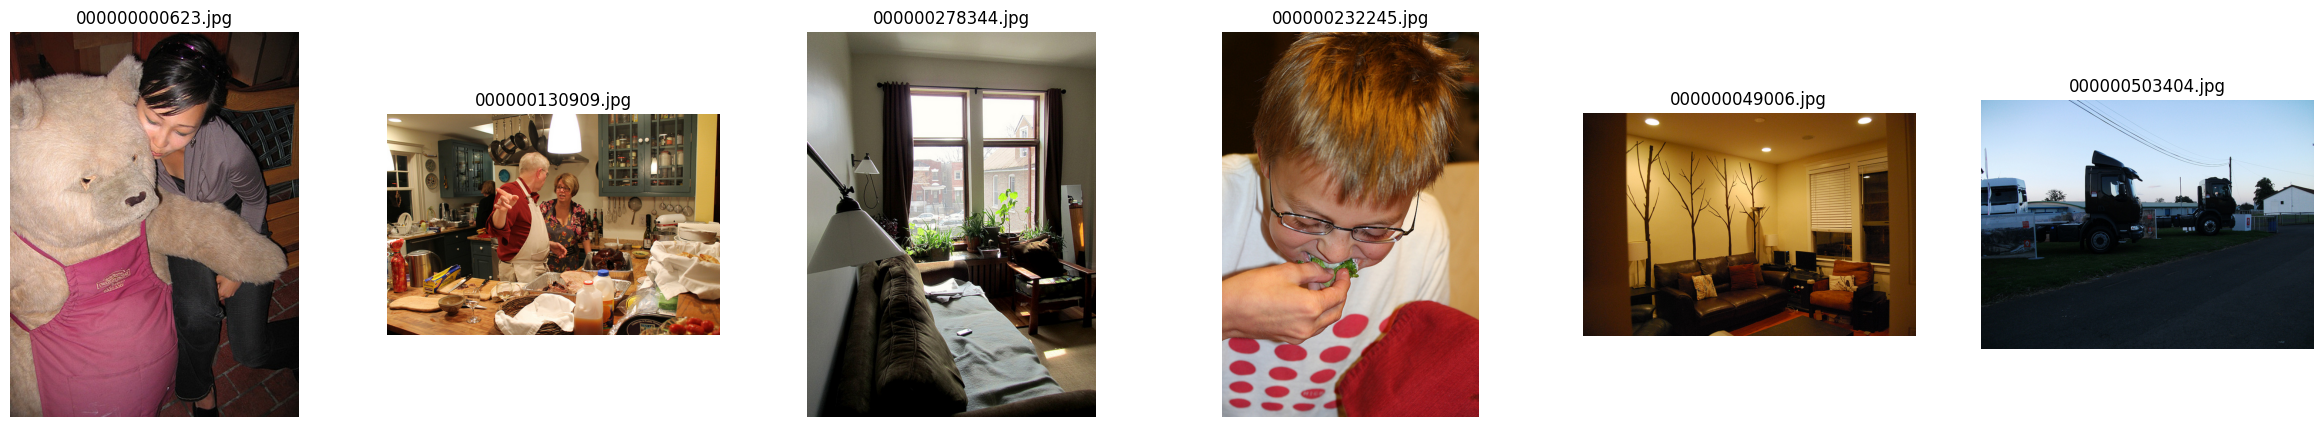

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

base_path = os.getcwd()  # Gets the current working directory
folder_path = os.path.join(base_path, 'Datasets_COCO', 'train2017')

# Get all files in the folder
files = [name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]

# Randomly select 6 files
random_files = random.sample(files, 6)

# Display the images
fig, axes = plt.subplots(1, 6, figsize=(30, 5))  # Adjust figsize to make the display larger
for ax, file in zip(axes, random_files):
    img = mpimg.imread(os.path.join(folder_path, file))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(file)

plt.show()


### SUBSET CREATION

In [1]:
from pycocotools.coco import COCO
from collections import defaultdict
import os, json, shutil, random

def create_balanced_subset_by_images_per_class(
    annotations_path,
    images_dir,
    subset_dir,
    target_class_ids,
    images_per_class=500
):
    coco = COCO(annotations_path)
    os.makedirs(os.path.join(subset_dir, 'images'), exist_ok=True)

    selected_image_ids = set()
    class_to_image_ids = defaultdict(list)

    # Get image ids per class
    for class_id in target_class_ids:
        img_ids = coco.getImgIds(catIds=[class_id])
        random.shuffle(img_ids)
        class_to_image_ids[class_id] = img_ids[:images_per_class]
        selected_image_ids.update(class_to_image_ids[class_id])

    # Prepare filtered data
    selected_images = coco.loadImgs(list(selected_image_ids))
    selected_annotations = []
    for img_id in selected_image_ids:
        anns = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
        anns = [ann for ann in anns if ann['category_id'] in target_class_ids]
        selected_annotations.extend(anns)

    # Filter categories
    selected_categories = [cat for cat in coco.loadCats(target_class_ids)]

    # Copy image files
    for img in selected_images:
        src = os.path.join(images_dir, img['file_name'])
        dst = os.path.join(subset_dir, 'images', img['file_name'])
        if os.path.exists(src):
            shutil.copy2(src, dst)

    # Save subset annotations
    subset_json = {
        "images": selected_images,
        "annotations": selected_annotations,
        "categories": selected_categories
    }

    with open(os.path.join(subset_dir, 'annotations.json'), 'w') as f:
        json.dump(subset_json, f)

    print(f"Subset created with:")
    for cid in target_class_ids:
        print(f" - Class {cid}: {len(class_to_image_ids[cid])} images")
    print(f" - Total images: {len(selected_images)}")
    print(f" - Total annotations: {len(selected_annotations)}")


In [2]:
base_path = os.getcwd()  # Gets the current working directory
create_balanced_subset_by_images_per_class(
    annotations_path=os.path.join(base_path, 'Datasets_COCO', 'annotations', 'instances_train2017.json'),
    images_dir=os.path.join(base_path, 'Datasets_COCO', 'train2017'),
    subset_dir=os.path.join(base_path, 'Datasets_COCO', 'subset_3_balanced'),
    target_class_ids=[1, 2, 3],  # person, bicycle, car
    images_per_class=2000
)


loading annotations into memory...
Done (t=14.52s)
creating index...
index created!
Subset created with:
 - Class 1: 2000 images
 - Class 2: 2000 images
 - Class 3: 2000 images
 - Total images: 5798
 - Total annotations: 39067


### VIEW SOME RANDOM IMAGES FROM SUBSET

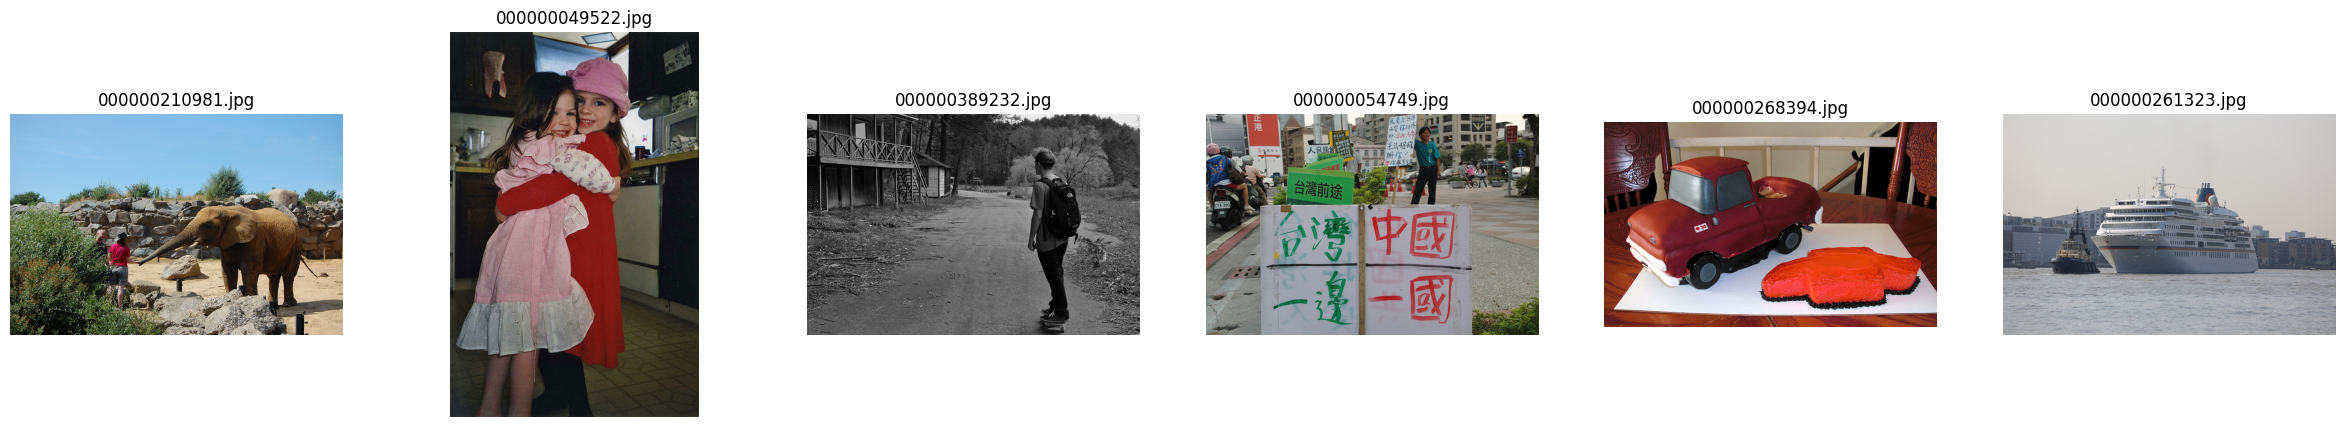

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


base_path = os.getcwd()  # Gets the current working directory
folder_path = os.path.join(base_path, 'Datasets_COCO', 'subset_3_balanced', 'images')

# Get all files in the folder
files = [name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]

# Randomly select 6 files
random_files = random.sample(files, 6)

# Display the images
fig, axes = plt.subplots(1, 6, figsize=(30, 5))  # Adjust figsize to make the display larger
for ax, file in zip(axes, random_files):
    img = mpimg.imread(os.path.join(folder_path, file))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(file)

plt.show()


### CATEGORIES OF THE SUBSET

In [1]:
from pycocotools.coco import COCO
import os

def print_categories_and_ids(subset_dir):
    """
    Prints all category names and their corresponding IDs from a COCO annotations file located in the specified subset directory.

    Args:
        subset_dir (str): Path to the directory containing the subset annotations JSON file.
    """

    # Construct the path to the annotations file
    annotations_path = os.path.join(subset_dir, 'annotations.json')

    try:
        coco = COCO(annotations_path)
        categories = coco.loadCats(coco.getCatIds())

        print("Available Categories and IDs:")
        print("----------------------------")
        for category in categories:
            print(f"Category ID: {category['id']}, Category Name: {category['name']}")

    except Exception as e:
        print(f"Error: Could not load or process annotations. {e}")


# --- Usage ---
# Define the path to the subset directory relative to the current working directory
base_path = os.getcwd()
subset_directory = os.path.join(base_path, 'Datasets_COCO', 'subset_3_balanced')
print_categories_and_ids(subset_directory)


loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
Available Categories and IDs:
----------------------------
Category ID: 1, Category Name: person
Category ID: 2, Category Name: bicycle
Category ID: 3, Category Name: car


### GENERATE SEMANTIC MASK

In [1]:
import json
import os
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import multiprocessing
from tqdm import tqdm

# --------- Fixed category-to-color map ---------
CATEGORY_COLOR_MAP = {
    1: (255, 0, 0, 255),     # Person - Red
    2: (0, 255, 0, 255),     # Bicycle - Green
    3: (0, 0, 255, 255),     # Car - Blue
}

def get_color_from_category(cat_id):
    return CATEGORY_COLOR_MAP.get(cat_id, (128, 128, 128, 255))  # Default: Gray

# --------- Global COCO object ---------
coco = None  # global COCO instance

# --------- Mask generator per image ---------
def process_image(data):
    global coco
    img_id, images_dir, output_dir = data
    img_info = coco.loadImgs(img_id)[0]
    image_path = os.path.join(images_dir, img_info['file_name'])
    mask_path = os.path.join(output_dir, img_info['file_name'].replace(".jpg", "_mask.png"))

    try:
        image = Image.open(image_path).convert('RGBA')
        mask_image = Image.new('RGBA', image.size, (0, 0, 0, 255))  # Start with black mask

        ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        category_mask_map = {}

        for ann in anns:
            cat_id = ann['category_id']
            if cat_id not in category_mask_map:
                category_mask_map[cat_id] = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
            mask = coco.annToMask(ann)
            category_mask_map[cat_id] = np.logical_or(category_mask_map[cat_id], mask)

        for cat_id, combined_mask in category_mask_map.items():
            color = get_color_from_category(cat_id)
            overlay = Image.new('RGBA', image.size, color)
            mask_pil = Image.fromarray((combined_mask * 255).astype('uint8'), mode='L')
            mask_image.paste(overlay, (0, 0), mask_pil)

        mask_image.save(mask_path)
    except Exception as e:
        print(f"Error processing {img_info['file_name']}: {e}")

# --------- Prepare processing data ---------
def prepare_data(annotations_path, images_dir, output_dir, num_images=None):
    global coco
    coco = COCO(annotations_path)
    image_ids = coco.getImgIds()
    if num_images:
        image_ids = image_ids[:num_images]
    return [(img_id, images_dir, output_dir) for img_id in image_ids]

# --------- Main execution ---------
def main():
    base_path = os.getcwd()
    annotations_path = os.path.join(base_path, 'Datasets_COCO', 'subset_3_balanced', 'annotations.json')
    images_dir = os.path.join(base_path, 'Datasets_COCO', 'subset_3_balanced', 'images')
    output_dir = os.path.join(base_path, 'Datasets_COCO', 'subset_3_balanced', 'masks')

    os.makedirs(output_dir, exist_ok=True)

    valid_images = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
    print(f"🔍 Found {len(valid_images)} .jpg files")

    data = prepare_data(annotations_path, images_dir, output_dir, num_images=len(valid_images))

    print("Starting mask generation...")
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        for _ in tqdm(pool.imap_unordered(process_image, data), total=len(data)):
            pass

    print("Finished generating semantic masks.")

if __name__ == "__main__":
    main()


🔍 Found 5813 .jpg files
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
Starting mask generation...


100%|██████████| 5813/5813 [00:02<00:00, 2094.91it/s]


Finished generating semantic masks.


### RANDOMLY VIEW THE GENERATED MASK ALONG WITH THE ORIGINAL & ANNOTATED IMAGES

loading annotations into memory...


Done (t=0.47s)
creating index...
index created!


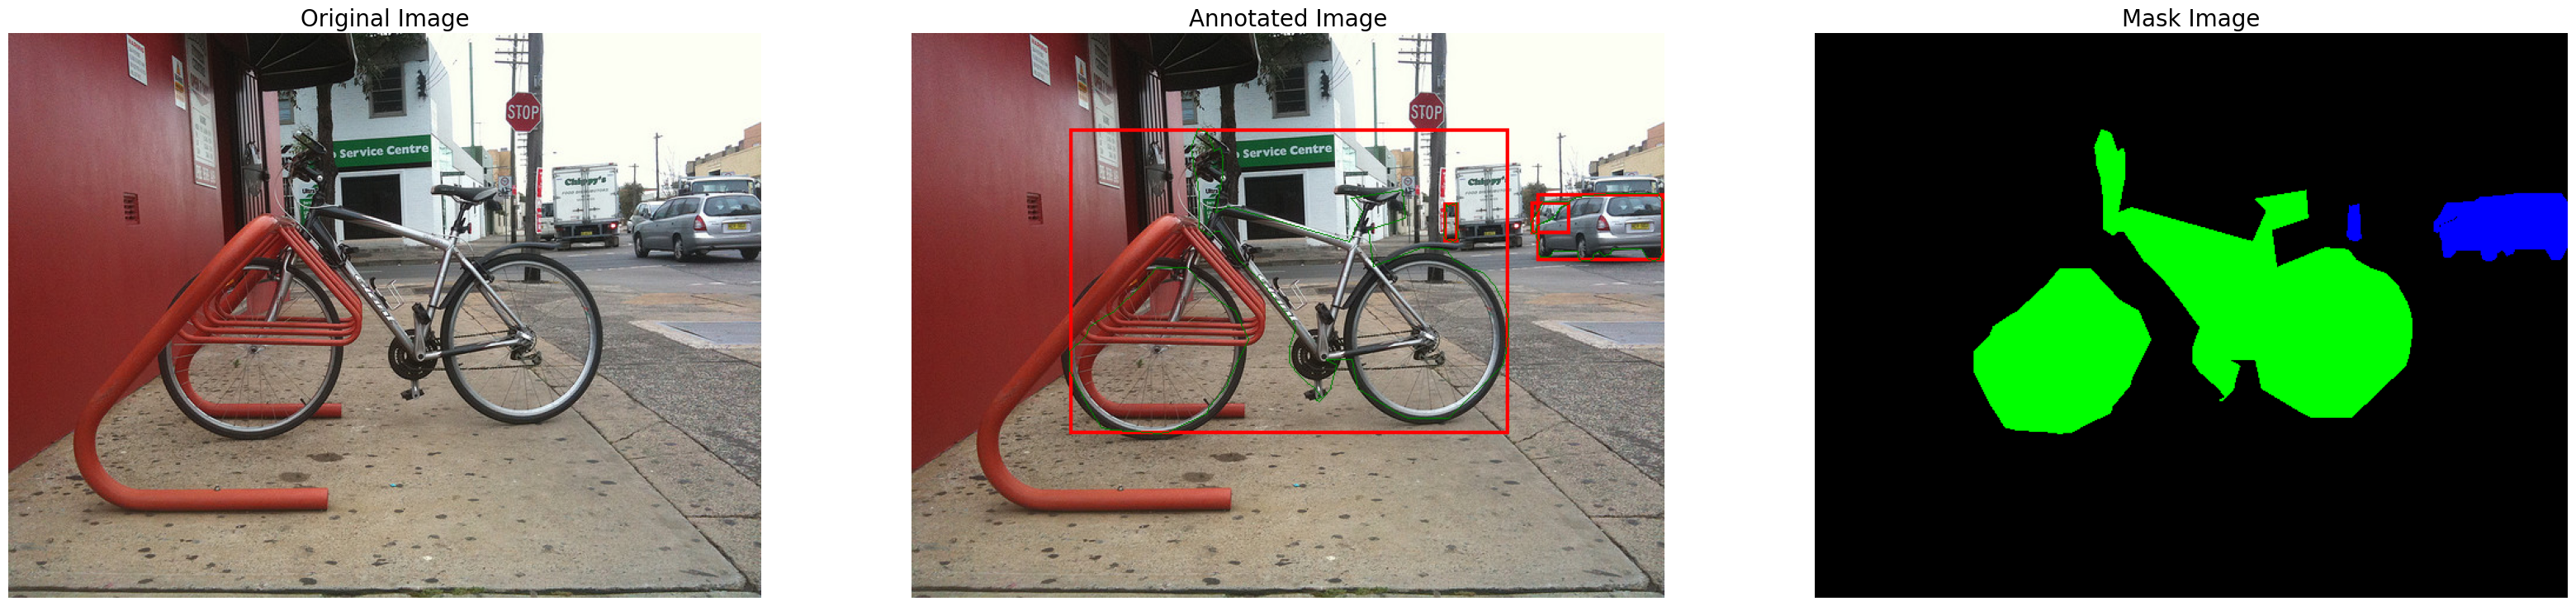

In [9]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import random
from pycocotools.coco import COCO

def display_images_with_annotations(base_path, subset_dir_name='subset_3_balanced', num_images=1):
    images_dir = os.path.join(base_path, 'subset_3_balanced', 'images')
    annotations_path = os.path.join(base_path, subset_dir_name, 'annotations.json')
    masks_dir = os.path.join(base_path, 'subset_3_balanced', 'masks')

    coco = COCO(annotations_path)  # Load annotations from the subset
    image_ids = list(coco.imgs.keys())  # Get IDs from the subset annotations
    selected_image_ids = random.sample(image_ids, num_images) if len(image_ids) > num_images else image_ids

    for img_id in selected_image_ids:
        img_info = coco.loadImgs(img_id)[0]
        image_path = os.path.join(images_dir, img_info['file_name'])
        original_image = Image.open(image_path)
        mask_path = os.path.join(masks_dir, img_info['file_name'].replace('.jpg', '_mask.png'))


        if not os.path.exists(mask_path):
            print(f"Mask file does not exist: {mask_path}")
            continue  # Skip this image or handle the error as needed

        mask_image = Image.open(mask_path)

        # Draw annotations directly on the image
        annotated_image = original_image.copy()
        draw = ImageDraw.Draw(annotated_image, 'RGBA')
        ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        for ann in anns:
            if 'bbox' in ann:
                bbox = ann['bbox']
                draw.rectangle([
                    (bbox[0], bbox[1]),
                    (bbox[0] + bbox[2], bbox[1] + bbox[3])
                ], outline='red', width=3)

            if 'segmentation' in ann:
                if isinstance(ann['segmentation'], list):
                    for segmentation in ann['segmentation']:
                        polygon = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
                        draw.polygon(polygon, outline='green')

        # Display images
        fig, axs = plt.subplots(1, 3, figsize=(40, 20)) 
        axs[0].imshow(original_image)
        axs[0].set_title('Original Image', fontsize=20)
        axs[0].axis('off')

        axs[1].imshow(annotated_image)
        axs[1].set_title('Annotated Image', fontsize=20)
        axs[1].axis('off')

        axs[2].imshow(mask_image)
        axs[2].set_title('Mask Image', fontsize=20)
        axs[2].axis('off')

        plt.show()

if __name__ == "__main__":
    base_path = os.getcwd() 
    display_images_with_annotations(os.path.join(base_path, 'Datasets_COCO'))


# TASK 2

In [1]:
import os
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

class SegmentationWithForegroundMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, annotation_path, transform=None, size=(512, 512), num_classes=4):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.size = size
        self.num_classes = num_classes
        self.images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.coco = COCO(annotation_path)
        self.color_map = {
            1: (255, 0, 0),   # person
            2: (0, 255, 0),   # bicycle
            3: (0, 0, 255)    # car
        }

    def _rgb_to_class(self, mask_np):
        H, W, _ = mask_np.shape
        flat_mask = mask_np.reshape(-1, 3)
        class_mask = np.zeros((H * W,), dtype=np.uint8)  # background = 0
        for class_id, rgb in self.color_map.items():
            matches = np.all(flat_mask == rgb, axis=1)
            class_mask[matches] = class_id
        return class_mask.reshape((H, W))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, img_name.replace('.jpg', '_mask.png'))).convert('RGB')

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        mask_np = np.array(mask)
        class_mask_np = self._rgb_to_class(mask_np)

        # Loss mask: foreground only (non-zero)
        loss_mask = (class_mask_np > 0).astype(np.uint8)

        # Convert to tensors
        class_mask = torch.tensor(class_mask_np, dtype=torch.long)
        loss_mask = torch.tensor(loss_mask, dtype=torch.float32)

        class_mask = F.interpolate(class_mask.unsqueeze(0).unsqueeze(0).float(), size=self.size, mode="nearest").squeeze().long()
        loss_mask = F.interpolate(loss_mask.unsqueeze(0).unsqueeze(0), size=self.size, mode="nearest").squeeze()

        return image, class_mask, loss_mask



In [2]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),  # Added dropout
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1)   # Added dropout
        )

    def forward(self, x):
        return self.double_conv(x)



class UNetMultiClass(nn.Module):
    def __init__(self, n_channels=3, n_classes=4):
        super(UNetMultiClass, self).__init__()
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = DoubleConv(32, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.up1 = DoubleConv(256 + 128, 128)
        self.up2 = DoubleConv(128 + 64, 64)
        self.up3 = DoubleConv(64 + 32, 32)
        self.outc = nn.Conv2d(32, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(self.pool(x1))
        x3 = self.down2(self.pool(x2))
        x4 = self.down3(self.pool(x3))
        x = self.up1(torch.cat([F.interpolate(x4, scale_factor=2), x3], dim=1))
        x = self.up2(torch.cat([F.interpolate(x, scale_factor=2), x2], dim=1))
        x = self.up3(torch.cat([F.interpolate(x, scale_factor=2), x1], dim=1))
        return self.outc(x)


In [3]:
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetMultiClass().to(device)

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])



dataset = SegmentationWithForegroundMaskDataset(
    image_dir='Datasets_COCO/subset_3_balanced/images',
    mask_dir='Datasets_COCO/subset_3_balanced/masks',
    annotation_path='Datasets_COCO/subset_3_balanced/annotations.json',
    transform=transform
)


train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)


# ---------- Focal Loss Masked ----------
class MaskedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target, mask):
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')

        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        focal_loss = focal_loss * mask  # Apply bounding box mask
        return focal_loss.sum() / (mask.sum() + 1e-6)

# ---------- Compute bounding box mask from segmentation ----------
def get_bbox_mask(mask_tensor):
    # mask_tensor: (B, H, W)
    B, H, W = mask_tensor.shape
    mask_out = torch.zeros((B, H, W), device=mask_tensor.device)

    for b in range(B):
        unique_labels = mask_tensor[b].unique()
        for cls in unique_labels:
            if cls == 0:  # Skip background
                continue
            y_indices, x_indices = (mask_tensor[b] == cls).nonzero(as_tuple=True)
            if len(y_indices) > 0:
                ymin, ymax = y_indices.min(), y_indices.max()
                xmin, xmax = x_indices.min(), x_indices.max()
                mask_out[b, ymin:ymax+1, xmin:xmax+1] = 1
    return mask_out


# ---------- Training with Bounding Box Mask + TensorBoard ----------
def train_model(model, train_loader, val_loader, device, num_epochs=100):
    weights = torch.tensor([0.5, 1, 1.0, 1.0]).to(device)
    criterion = MaskedFocalLoss(gamma=2.0, weight=weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scaler = torch.amp.GradScaler()

    writer = SummaryWriter(log_dir="runs/segmentation_experiment")  # <-- TensorBoard writer

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    patience = 10
    early_stop_counter = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            images, masks = batch[0].to(device), batch[1].to(device)
            loss_mask = get_bbox_mask(masks)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks, loss_mask)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)  # <-- TensorBoard log

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
                images, masks = batch[0].to(device), batch[1].to(device)
                loss_mask = get_bbox_mask(masks)

                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, masks, loss_mask)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        writer.add_scalar("Loss/Validation", avg_val_loss, epoch)  # <-- TensorBoard log

        print(f"📉 Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0  # reset counter
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Best model saved!")
        else:
            early_stop_counter += 1
            print(f"🕓 Early stop counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("⛔ Early stopping triggered!")
                break


    writer.close()  # <-- Close the writer

    # ---------- Plot ----------
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


2025-04-16 18:49:04.609808: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 18:49:05.225123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


Val Epoch 1: 100%|██████████| 146/146 [00:07<00:00, 20.18it/s]


📉 Epoch 1: Train Loss = 0.3290, Val Loss = 0.3128
✅ Best model saved!


Val Epoch 2: 100%|██████████| 146/146 [00:07<00:00, 20.67it/s]


📉 Epoch 2: Train Loss = 0.3132, Val Loss = 0.3132
🕓 Early stop counter: 1/10


Val Epoch 3: 100%|██████████| 146/146 [00:07<00:00, 20.45it/s]


📉 Epoch 3: Train Loss = 0.3062, Val Loss = 0.2960
✅ Best model saved!


Val Epoch 4: 100%|██████████| 146/146 [00:07<00:00, 20.24it/s]


📉 Epoch 4: Train Loss = 0.2965, Val Loss = 0.2838
✅ Best model saved!


Val Epoch 5: 100%|██████████| 146/146 [00:07<00:00, 20.22it/s]


📉 Epoch 5: Train Loss = 0.2906, Val Loss = 0.2817
✅ Best model saved!


Val Epoch 6: 100%|██████████| 146/146 [00:07<00:00, 20.63it/s]


📉 Epoch 6: Train Loss = 0.2896, Val Loss = 0.2840
🕓 Early stop counter: 1/10


Val Epoch 7: 100%|██████████| 146/146 [00:07<00:00, 20.34it/s]


📉 Epoch 7: Train Loss = 0.2855, Val Loss = 0.2702
✅ Best model saved!


Val Epoch 8: 100%|██████████| 146/146 [00:07<00:00, 20.76it/s]


📉 Epoch 8: Train Loss = 0.2812, Val Loss = 0.2808
🕓 Early stop counter: 1/10


Val Epoch 9: 100%|██████████| 146/146 [00:07<00:00, 20.44it/s]


📉 Epoch 9: Train Loss = 0.2778, Val Loss = 0.2687
✅ Best model saved!


Val Epoch 10: 100%|██████████| 146/146 [00:07<00:00, 20.35it/s]


📉 Epoch 10: Train Loss = 0.2730, Val Loss = 0.2626
✅ Best model saved!


Val Epoch 11: 100%|██████████| 146/146 [00:07<00:00, 20.71it/s]


📉 Epoch 11: Train Loss = 0.2703, Val Loss = 0.2563
✅ Best model saved!


Val Epoch 12: 100%|██████████| 146/146 [00:07<00:00, 20.39it/s]


📉 Epoch 12: Train Loss = 0.2666, Val Loss = 0.2679
🕓 Early stop counter: 1/10


Val Epoch 13: 100%|██████████| 146/146 [00:06<00:00, 21.01it/s]


📉 Epoch 13: Train Loss = 0.2604, Val Loss = 0.2550
✅ Best model saved!


Val Epoch 14: 100%|██████████| 146/146 [00:07<00:00, 20.46it/s]


📉 Epoch 14: Train Loss = 0.2585, Val Loss = 0.2673
🕓 Early stop counter: 1/10


Val Epoch 15: 100%|██████████| 146/146 [00:07<00:00, 20.32it/s]


📉 Epoch 15: Train Loss = 0.2622, Val Loss = 0.2509
✅ Best model saved!


Val Epoch 16: 100%|██████████| 146/146 [00:07<00:00, 20.36it/s]


📉 Epoch 16: Train Loss = 0.2557, Val Loss = 0.2455
✅ Best model saved!


Val Epoch 17: 100%|██████████| 146/146 [00:07<00:00, 20.82it/s]


📉 Epoch 17: Train Loss = 0.2507, Val Loss = 0.2634
🕓 Early stop counter: 1/10


Val Epoch 18: 100%|██████████| 146/146 [00:07<00:00, 20.76it/s]


📉 Epoch 18: Train Loss = 0.2521, Val Loss = 0.2407
✅ Best model saved!


Val Epoch 19: 100%|██████████| 146/146 [00:07<00:00, 20.45it/s]


📉 Epoch 19: Train Loss = 0.2512, Val Loss = 0.2510
🕓 Early stop counter: 1/10


Val Epoch 20: 100%|██████████| 146/146 [00:07<00:00, 20.72it/s]


📉 Epoch 20: Train Loss = 0.2463, Val Loss = 0.2548
🕓 Early stop counter: 2/10


Val Epoch 21: 100%|██████████| 146/146 [00:07<00:00, 20.36it/s]


📉 Epoch 21: Train Loss = 0.2456, Val Loss = 0.2450
🕓 Early stop counter: 3/10


Val Epoch 22: 100%|██████████| 146/146 [00:07<00:00, 20.76it/s]


📉 Epoch 22: Train Loss = 0.2436, Val Loss = 0.2406
✅ Best model saved!


Val Epoch 23: 100%|██████████| 146/146 [00:07<00:00, 20.24it/s]


📉 Epoch 23: Train Loss = 0.2418, Val Loss = 0.2443
🕓 Early stop counter: 1/10


Val Epoch 24: 100%|██████████| 146/146 [00:07<00:00, 20.44it/s]


📉 Epoch 24: Train Loss = 0.2375, Val Loss = 0.2242
✅ Best model saved!


Val Epoch 25: 100%|██████████| 146/146 [00:07<00:00, 20.48it/s]


📉 Epoch 25: Train Loss = 0.2343, Val Loss = 0.2357
🕓 Early stop counter: 1/10


Val Epoch 26: 100%|██████████| 146/146 [00:07<00:00, 20.58it/s]


📉 Epoch 26: Train Loss = 0.2368, Val Loss = 0.2330
🕓 Early stop counter: 2/10


Val Epoch 27: 100%|██████████| 146/146 [00:07<00:00, 20.26it/s]


📉 Epoch 27: Train Loss = 0.2323, Val Loss = 0.2266
🕓 Early stop counter: 3/10


Val Epoch 28: 100%|██████████| 146/146 [00:07<00:00, 20.76it/s]


📉 Epoch 28: Train Loss = 0.2306, Val Loss = 0.2225
✅ Best model saved!


Val Epoch 29: 100%|██████████| 146/146 [00:07<00:00, 20.00it/s]


📉 Epoch 29: Train Loss = 0.2344, Val Loss = 0.2229
🕓 Early stop counter: 1/10


Val Epoch 30: 100%|██████████| 146/146 [00:06<00:00, 20.86it/s]


📉 Epoch 30: Train Loss = 0.2279, Val Loss = 0.2462
🕓 Early stop counter: 2/10


Val Epoch 31: 100%|██████████| 146/146 [00:07<00:00, 20.35it/s]


📉 Epoch 31: Train Loss = 0.2239, Val Loss = 0.2275
🕓 Early stop counter: 3/10


Val Epoch 32: 100%|██████████| 146/146 [00:07<00:00, 20.71it/s]


📉 Epoch 32: Train Loss = 0.2224, Val Loss = 0.2252
🕓 Early stop counter: 4/10


Val Epoch 33: 100%|██████████| 146/146 [00:06<00:00, 20.86it/s]


📉 Epoch 33: Train Loss = 0.2230, Val Loss = 0.2201
✅ Best model saved!


Val Epoch 34: 100%|██████████| 146/146 [00:07<00:00, 20.17it/s]


📉 Epoch 34: Train Loss = 0.2257, Val Loss = 0.2291
🕓 Early stop counter: 1/10


Val Epoch 35: 100%|██████████| 146/146 [00:07<00:00, 20.34it/s]


📉 Epoch 35: Train Loss = 0.2220, Val Loss = 0.2148
✅ Best model saved!


Val Epoch 36: 100%|██████████| 146/146 [00:07<00:00, 20.54it/s]


📉 Epoch 36: Train Loss = 0.2214, Val Loss = 0.2210
🕓 Early stop counter: 1/10


Val Epoch 37: 100%|██████████| 146/146 [00:07<00:00, 20.58it/s]


📉 Epoch 37: Train Loss = 0.2197, Val Loss = 0.2266
🕓 Early stop counter: 2/10


Val Epoch 38: 100%|██████████| 146/146 [00:07<00:00, 20.34it/s]


📉 Epoch 38: Train Loss = 0.2206, Val Loss = 0.2097
✅ Best model saved!


Val Epoch 39: 100%|██████████| 146/146 [00:07<00:00, 20.34it/s]


📉 Epoch 39: Train Loss = 0.2182, Val Loss = 0.2101
🕓 Early stop counter: 1/10


Val Epoch 40: 100%|██████████| 146/146 [00:07<00:00, 20.38it/s]


📉 Epoch 40: Train Loss = 0.2202, Val Loss = 0.2319
🕓 Early stop counter: 2/10


Val Epoch 41: 100%|██████████| 146/146 [00:07<00:00, 20.72it/s]


📉 Epoch 41: Train Loss = 0.2195, Val Loss = 0.2200
🕓 Early stop counter: 3/10


Val Epoch 42: 100%|██████████| 146/146 [00:07<00:00, 20.64it/s]


📉 Epoch 42: Train Loss = 0.2157, Val Loss = 0.2114
🕓 Early stop counter: 4/10


Val Epoch 43: 100%|██████████| 146/146 [00:07<00:00, 20.11it/s]


📉 Epoch 43: Train Loss = 0.2169, Val Loss = 0.2222
🕓 Early stop counter: 5/10


Val Epoch 44: 100%|██████████| 146/146 [00:07<00:00, 20.58it/s]


📉 Epoch 44: Train Loss = 0.2188, Val Loss = 0.2080
✅ Best model saved!


Val Epoch 45: 100%|██████████| 146/146 [00:07<00:00, 20.80it/s]


📉 Epoch 45: Train Loss = 0.2142, Val Loss = 0.2197
🕓 Early stop counter: 1/10


Val Epoch 46: 100%|██████████| 146/146 [00:07<00:00, 20.73it/s]


📉 Epoch 46: Train Loss = 0.2137, Val Loss = 0.2094
🕓 Early stop counter: 2/10


Val Epoch 47: 100%|██████████| 146/146 [00:06<00:00, 20.87it/s]


📉 Epoch 47: Train Loss = 0.2110, Val Loss = 0.2094
🕓 Early stop counter: 3/10


Val Epoch 48: 100%|██████████| 146/146 [00:07<00:00, 20.54it/s]


📉 Epoch 48: Train Loss = 0.2129, Val Loss = 0.2058
✅ Best model saved!


Val Epoch 49: 100%|██████████| 146/146 [00:07<00:00, 20.32it/s]


📉 Epoch 49: Train Loss = 0.2121, Val Loss = 0.2044
✅ Best model saved!


Val Epoch 50: 100%|██████████| 146/146 [00:07<00:00, 20.83it/s]


📉 Epoch 50: Train Loss = 0.2088, Val Loss = 0.2245
🕓 Early stop counter: 1/10


Val Epoch 51: 100%|██████████| 146/146 [00:07<00:00, 20.52it/s]


📉 Epoch 51: Train Loss = 0.2111, Val Loss = 0.2111
🕓 Early stop counter: 2/10


Val Epoch 52: 100%|██████████| 146/146 [00:07<00:00, 20.09it/s]


📉 Epoch 52: Train Loss = 0.2102, Val Loss = 0.2063
🕓 Early stop counter: 3/10


Val Epoch 53: 100%|██████████| 146/146 [00:07<00:00, 20.61it/s]


📉 Epoch 53: Train Loss = 0.2081, Val Loss = 0.2035
✅ Best model saved!


Val Epoch 54: 100%|██████████| 146/146 [00:07<00:00, 20.71it/s]


📉 Epoch 54: Train Loss = 0.2123, Val Loss = 0.2051
🕓 Early stop counter: 1/10


Val Epoch 55: 100%|██████████| 146/146 [00:07<00:00, 20.36it/s]


📉 Epoch 55: Train Loss = 0.2077, Val Loss = 0.2065
🕓 Early stop counter: 2/10


Val Epoch 56: 100%|██████████| 146/146 [00:10<00:00, 13.57it/s]


📉 Epoch 56: Train Loss = 0.2098, Val Loss = 0.2082
🕓 Early stop counter: 3/10


Val Epoch 57: 100%|██████████| 146/146 [00:07<00:00, 20.59it/s]


📉 Epoch 57: Train Loss = 0.2097, Val Loss = 0.2031
✅ Best model saved!


Val Epoch 58: 100%|██████████| 146/146 [00:11<00:00, 12.24it/s]


📉 Epoch 58: Train Loss = 0.2080, Val Loss = 0.2186
🕓 Early stop counter: 1/10


Val Epoch 59: 100%|██████████| 146/146 [00:10<00:00, 13.55it/s]


📉 Epoch 59: Train Loss = 0.2020, Val Loss = 0.2112
🕓 Early stop counter: 2/10


Val Epoch 60: 100%|██████████| 146/146 [00:11<00:00, 12.17it/s]


📉 Epoch 60: Train Loss = 0.2083, Val Loss = 0.2198
🕓 Early stop counter: 3/10


Val Epoch 61: 100%|██████████| 146/146 [00:07<00:00, 19.97it/s]


📉 Epoch 61: Train Loss = 0.2027, Val Loss = 0.2116
🕓 Early stop counter: 4/10


Val Epoch 62: 100%|██████████| 146/146 [00:06<00:00, 20.91it/s]


📉 Epoch 62: Train Loss = 0.2066, Val Loss = 0.1951
✅ Best model saved!


Val Epoch 63: 100%|██████████| 146/146 [00:06<00:00, 20.87it/s]


📉 Epoch 63: Train Loss = 0.2063, Val Loss = 0.2270
🕓 Early stop counter: 1/10


Val Epoch 64: 100%|██████████| 146/146 [00:07<00:00, 20.29it/s]


📉 Epoch 64: Train Loss = 0.2027, Val Loss = 0.2326
🕓 Early stop counter: 2/10


Val Epoch 65: 100%|██████████| 146/146 [00:07<00:00, 20.80it/s]


📉 Epoch 65: Train Loss = 0.2066, Val Loss = 0.2060
🕓 Early stop counter: 3/10


Val Epoch 66: 100%|██████████| 146/146 [00:07<00:00, 20.66it/s]


📉 Epoch 66: Train Loss = 0.2062, Val Loss = 0.2116
🕓 Early stop counter: 4/10


Val Epoch 67: 100%|██████████| 146/146 [00:07<00:00, 20.45it/s]


📉 Epoch 67: Train Loss = 0.2055, Val Loss = 0.1991
🕓 Early stop counter: 5/10


Val Epoch 68: 100%|██████████| 146/146 [00:06<00:00, 20.86it/s]


📉 Epoch 68: Train Loss = 0.1995, Val Loss = 0.2041
🕓 Early stop counter: 6/10


Val Epoch 69: 100%|██████████| 146/146 [00:07<00:00, 20.82it/s]


📉 Epoch 69: Train Loss = 0.2010, Val Loss = 0.2098
🕓 Early stop counter: 7/10


Val Epoch 70: 100%|██████████| 146/146 [00:07<00:00, 20.76it/s]


📉 Epoch 70: Train Loss = 0.1986, Val Loss = 0.2071
🕓 Early stop counter: 8/10


Val Epoch 71: 100%|██████████| 146/146 [00:07<00:00, 20.70it/s]


📉 Epoch 71: Train Loss = 0.2009, Val Loss = 0.1952
🕓 Early stop counter: 9/10


Val Epoch 72: 100%|██████████| 146/146 [00:07<00:00, 20.38it/s]


📉 Epoch 72: Train Loss = 0.1995, Val Loss = 0.2439
🕓 Early stop counter: 10/10
⛔ Early stopping triggered!


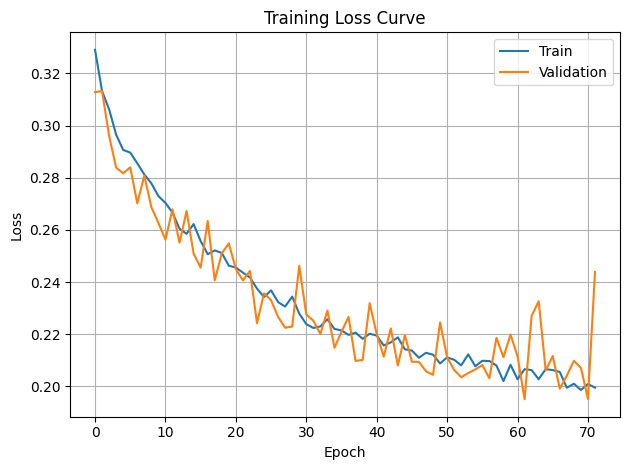

In [4]:
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=100)

In [5]:
import os
import torch
# Automatically get current directory
base_path = os.getcwd()
model_path = os.path.join(base_path, "best_model.pth")

# Load model
model = UNetMultiClass(n_channels=3, n_classes=4) 
model.load_state_dict(torch.load(model_path, map_location='cuda'))
model = model.to('cuda')
model.eval()


/tmp/ipykernel_1240126/2327458199.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cuda'))


UNetMultiClass(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.1, inplace=False)
    )
  )
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [7]:
def get_bbox_mask(masks):
    B, H, W = masks.shape
    loss_mask = torch.zeros_like(masks, dtype=torch.bool)
    for i in range(B):
        obj_indices = (masks[i] > 0).nonzero(as_tuple=False)
        if obj_indices.numel() == 0:
            continue
        y_min, x_min = obj_indices.min(dim=0).values
        y_max, x_max = obj_indices.max(dim=0).values
        loss_mask[i, y_min:y_max+1, x_min:x_max+1] = True
    return loss_mask
def evaluate_segmentation(model, dataloader, num_classes=4, device='cuda', use_bbox_mask=False):
    model.eval()
    intersection = torch.zeros(num_classes, dtype=torch.float64).to(device)
    union = torch.zeros(num_classes, dtype=torch.float64).to(device)
    tp = torch.zeros(num_classes, dtype=torch.float64).to(device)
    fp = torch.zeros(num_classes, dtype=torch.float64).to(device)
    fn = torch.zeros(num_classes, dtype=torch.float64).to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch[0].to(device), batch[1].to(device)

            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            if use_bbox_mask:
                loss_mask = get_bbox_mask(masks)
                preds = preds[loss_mask]
                masks = masks[loss_mask]

            for cls in range(num_classes):
                pred_inds = (preds == cls)
                target_inds = (masks == cls)

                intersection[cls] += (pred_inds & target_inds).sum()
                union[cls] += (pred_inds | target_inds).sum()
                tp[cls] += (pred_inds & target_inds).sum()
                fp[cls] += (pred_inds & (~target_inds)).sum()
                fn[cls] += ((~pred_inds) & target_inds).sum()

            correct += (preds == masks).sum()
            total += masks.numel()

    pixel_accuracy = (correct.float() / total).item()
    iou = intersection / (union + 1e-6)
    miou = iou.mean().item()
    f1 = (2 * tp) / (2 * tp + fp + fn + 1e-6)
    mean_f1 = f1.mean().item()

    return {
        "Pixel Accuracy": pixel_accuracy,
        "Mean IoU": miou,
        "Mean F1 Score": mean_f1,
        "Per-class IoU": iou.tolist(),
        "Per-class F1": f1.tolist()
    }


In [8]:
metrics = evaluate_segmentation(model, test_loader, num_classes=4, device=device, use_bbox_mask=True)
print("Pixel Accuracy:", metrics["Pixel Accuracy"])
print("Mean IoU:", metrics["Mean IoU"])
print("Mean F1 Score:", metrics["Mean F1 Score"])

Pixel Accuracy: 0.6281300783157349
Mean IoU: 0.38335143996182375
Mean F1 Score: 0.5443127784377904


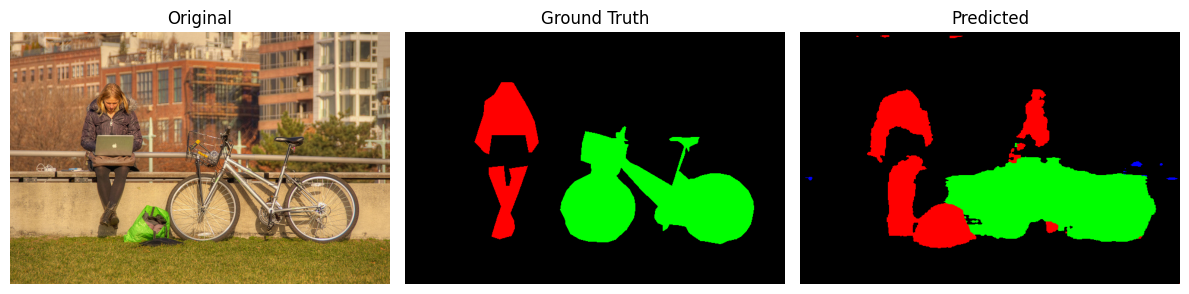

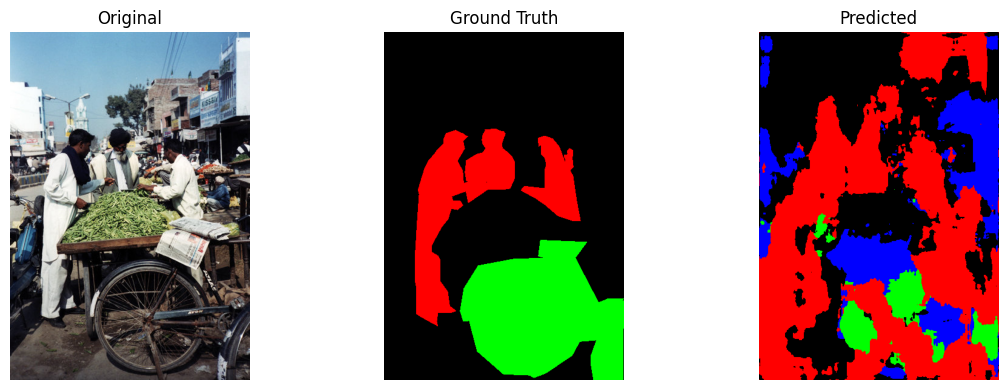

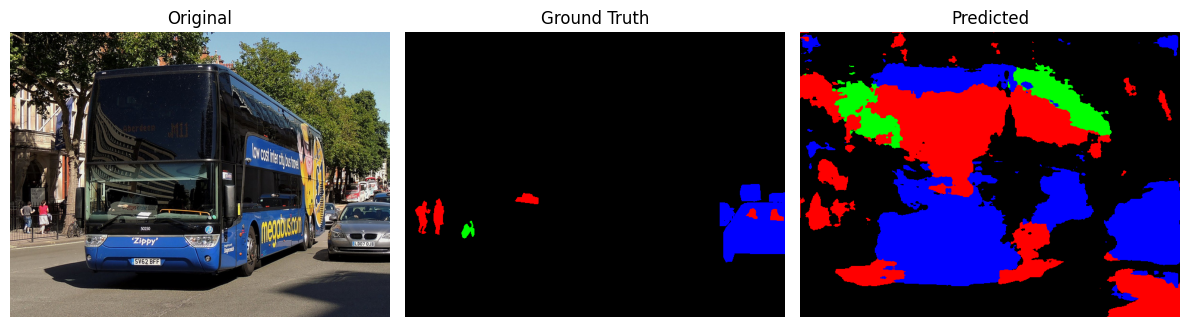

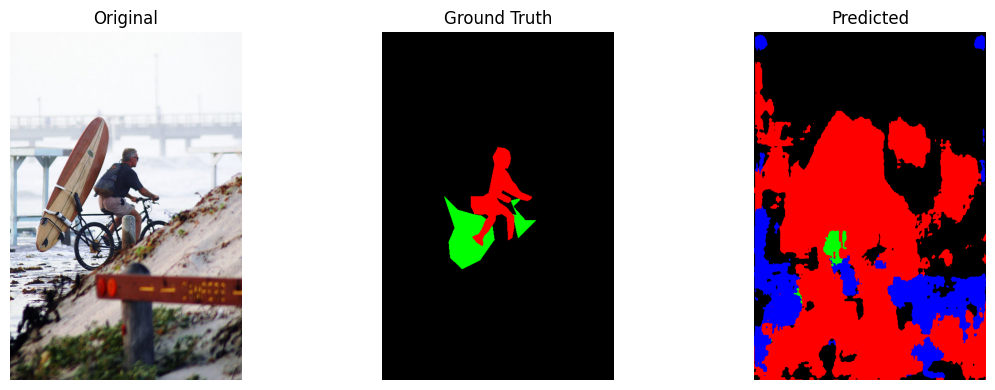

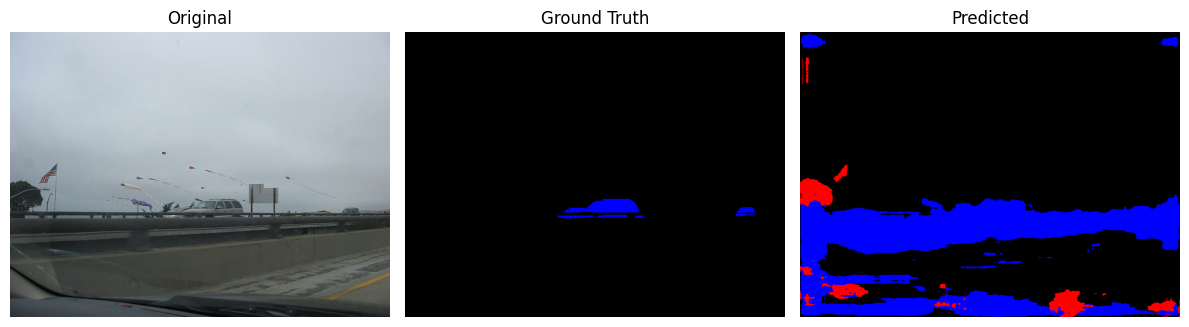

In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ---------------------- Mapping Definitions ----------------------
INV_CATEGORY_COLOR_MAP = {
    (0, 0, 0, 255): 0,         # Background
    (255, 0, 0, 255): 1,       # Person
    (0, 255, 0, 255): 2,       # Bicycle
    (0, 0, 255, 255): 3,       # Car
}

CLASS_COLORS = {
    0: (0, 0, 0),       # Background - black
    1: (255, 0, 0),     # Person - red
    2: (0, 255, 0),     # Bicycle - green
    3: (0, 0, 255),     # Car - blue
}

# ---------------------- Utilities ----------------------
def color_mask_to_class_index(mask_rgba):
    mask_np = np.array(mask_rgba)
    H, W, _ = mask_np.shape
    class_mask = np.zeros((H, W), dtype=np.uint8)

    for color, class_id in INV_CATEGORY_COLOR_MAP.items():
        matches = np.all(mask_np == color, axis=-1)
        class_mask[matches] = class_id

    return class_mask

def decode_segmap(mask):
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        color_mask[mask == class_id] = color
    return color_mask

# ---------------------- Visualization ----------------------
def visualize_random_predictions(model, image_dir, mask_dir, transform, device='cuda', num_samples=5):
    model.eval()
    all_images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
    sampled_images = random.sample(all_images, num_samples)

    for image_name in sampled_images:
        image_path = os.path.join(image_dir, image_name)
        mask_path = os.path.join(mask_dir, image_name.replace(".jpg", "_mask.png"))

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask_rgba = Image.open(mask_path).convert("RGBA")
        original_size = image.size

        # Transform image for model input
        image_tensor = transform(image).unsqueeze(0).to(device)
        true_mask = color_mask_to_class_index(mask_rgba)

        # Predict
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda'):
                output = model(image_tensor)
                pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Resize predicted mask to match original image size
        pred_mask_resized = Image.fromarray(pred_mask.astype(np.uint8)).resize(original_size, resample=Image.NEAREST)
        pred_colored = decode_segmap(np.array(pred_mask_resized))

        # Convert original and GT to numpy arrays
        img_np = np.array(image)
        true_colored = decode_segmap(true_mask)

        # Plot
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img_np)
        axs[0].set_title('Original')
        axs[1].imshow(true_colored)
        axs[1].set_title('Ground Truth')
        axs[2].imshow(pred_colored)
        axs[2].set_title('Predicted')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# ---------------------- Example Usage ----------------------
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

base_path = os.getcwd()
image_dir = os.path.join(base_path, 'Datasets_COCO', 'subset_3_balanced', 'images')
mask_dir = os.path.join(base_path, 'Datasets_COCO', 'subset_3_balanced', 'masks')

visualize_random_predictions(model, image_dir, mask_dir, transform, device=device, num_samples=5)
